# 9장. 비지도 학습 - 추천 알고리즘

---

## 학습 목표
- 추천 알고리즘의 의미를 이해합니다.
- Collaborative Filtering, Latent Factor Model를 사용하여 추천 알고리즘을 시행해봅니다.

---

## 목차

### 1. 추천 알고리즘
1. Item-item Collaborative Filtering
2. User-user Collaborative Filtering
3. Latent Factor Model


---

## 1. 추천 알고리즘

### 1-1. Item-item Collaborative Filtering

Item-based collaborative filtering은 Item 간의 유사도 (Pearson correlation)을 계산하여 Unrated item에 대한 rating을 예측하고, 이를 바탕으로 User recommendation을 가능하게 하는 알고리즘입니다.

이번 데모에서는 Movielens 100K 데이터의 영화 평가 점수 (Rating)을 이용한 Item-based collaborative filtering 을 다룹니다.

### 데이터

Movielens 100K 데이터를 사용합니다. Movielens 100K 데이터에는 다음과 같은 정보가 포함되어 있습니다.

1. 100,000 ratings (1-5) from 943 users on 1682 movies.
2. Each user has rated at least 20 movies.
3. Simple demographic info for the users (age, gender, occupation, zip)
4. Genre information of movies

### 출력

`user_id`에 따라 유저에게 추천 영화와 유저가 이미 높은 점수로 평가했던 영화를 차례로 출력합니다.

1. 예측한 영화 평가 점수가 높은 (추천 영화) 10개 영화 제목과 장르
2. 영화 평가 점수가 높았던 (평가된 영화) 10개 영화의 제목과 장르

### 함수

`data_to_dict` 함수는 Pandas table 형태로 된 데이터를 Dictionary 형태로 전환하는 함수입니다.

`pearson_correlation` 함수는 item1과 item2간의 Pearson correlation을 계산합니다. Pearson correlation에 대한 자세한 수식은 다음과 같습니다. 

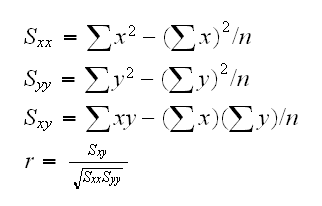

#### 예시

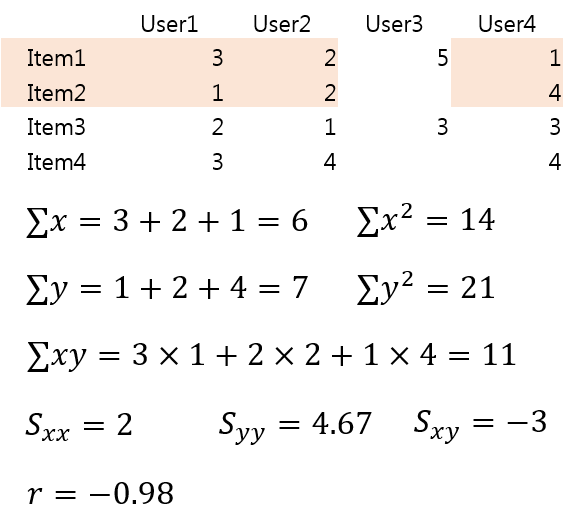

`calc_corr` : 모든 item 짝에 대해 Pearson correlation을 구합니다. 이 데모에서는 시간상 미리 구한 값을 불러오도록 하였습니다.

`predict` : 주어진 user_id에 대해 Item간 Pearson correlation과 User rating을 기반으로 Unrated item에 대한 ratings 예측값을 반환합니다.

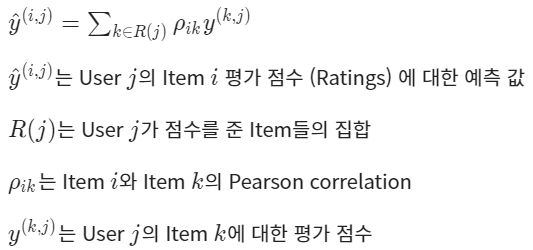

In [1]:
import pandas as pd
import numpy as np
import operator

def data_to_dict(id1, id2, ratings):
    dict_data = {}

    for _id1_ in sorted(ratings[id1].unique()):
        indices = (ratings[id1] == _id1_)
        
        dict_data[_id1_] = {}
        
        for _id2_, rating in zip(ratings[indices][id2], ratings[indices]['rating']):
            dict_data[_id1_][_id2_] = float(rating)
    
    return dict_data

def pearson_correlation(dict_data, item1, item2):
    # To get both rated items
    both_rated = {}
    for user in dict_data[item1]:
        if user in dict_data[item2]:
            both_rated[user] = 1

    number_of_ratings = len(both_rated)        
    
    # Checking for number of ratings in common
    if number_of_ratings == 0:
        return 0

    # Add up all the preferences of each user
    item1_preferences_sum = sum([dict_data[item1][user] for user in both_rated])
    item2_preferences_sum = sum([dict_data[item2][user] for user in both_rated])

    # Sum up the squares of preferences of each user
    item1_square_preferences_sum = sum([pow(dict_data[item1][user],2) for user in both_rated])
    item2_square_preferences_sum = sum([pow(dict_data[item2][user],2) for user in both_rated])

    # Sum up the product value of both preferences for each user
    product_sum_of_both_items = sum([dict_data[item1][user] * dict_data[item2][user] for user in both_rated])

    # Calculate the pearson score
    numerator_value = product_sum_of_both_items - (item1_preferences_sum * item2_preferences_sum / number_of_ratings)
    denominator_value = np.sqrt((item1_square_preferences_sum - pow(item1_preferences_sum, 2) / number_of_ratings) \
    * (item2_square_preferences_sum - pow(item2_preferences_sum, 2) / number_of_ratings))
    
    if denominator_value == 0:
        return 0
    else:
        r = numerator_value/denominator_value
        return r

def calc_corr(dict_data):
    M = len(dict_data)
    corr = np.ones([M + 1, M + 1])
    
    for i in range(1, M + 1):
        for j in range(i + 1, M + 1):
            corr[i, j] = pearson_correlation(dict_data, i, j)
            corr[j, i] = corr[i, j]
    
    np.save('corr_item.npy',corr)
    
    return corr

def predict(ratings, dict_data, corr, user):
    # Define a dictation for seen movies 
    seen_dict = {}
    
    # Obtain ratings of seen movies rated by the user
    for movie, rating in zip(ratings[(ratings['user_id'] == user)]['movie_id'], ratings[(ratings['user_id'] == user)]['rating']):
        seen_dict[movie] = float(rating)
    
    # Define a dictation for unseen movies 
    unseen_dict = {}
    
    # Obtain IDs of unseen movies 
    unseen_movies = set(movie_user_data) - set(ratings[(ratings['user_id'] == user)]['movie_id'])
    
    # Predict ratings for unseen movies
    for unseen_movie in unseen_movies:
        # Define numerator and denominator
        numer = 0
        denom = 0
        
        # Calculate numerator and denominator
        for seen_movie in seen_dict:
            if corr[unseen_movie, seen_movie] > 0:
                numer += corr[unseen_movie, seen_movie] * seen_dict[seen_movie]
                denom += corr[unseen_movie, seen_movie]
        
        # Predict for the uncorrelated item
        if denom == 0:
            unseen_dict[unseen_movie] = np.mean((ratings[(ratings['movie_id'] == unseen_movie)]['rating']))
            
        # Predict for the correlated item
        else:
            unseen_dict[unseen_movie] = numer / denom
                   
    return sorted(unseen_dict.items(), key = operator.itemgetter(1))

# Reading users file
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=u_cols,
 encoding='latin-1')

# Reading ratings file
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=r_cols,
 encoding='latin-1')

# Reading items file
i_cols = ['movie_id', 'movie title' ,'release date','video release date', 'IMDb URL', 'unknown', 'Action', 'Adventure',
 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
items = pd.read_csv('ml-100k/u.item', sep='|', names=i_cols,
 encoding='latin-1')

# Change data from pandas table to dictionary
movie_user_data = data_to_dict('movie_id', 'user_id', ratings)
user_movie_data = data_to_dict('user_id', 'movie_id', ratings)

# Calculate correlation among items
try:
    corr = np.load('corr_item.npy')
except:
    corr = calc_corr(movie_user_data)

# Recommend movies by predicting ratings
user_id = 200

recommendation = predict(ratings, movie_user_data, corr, user_id)
toprated = sorted(user_movie_data[user_id].items(), key = operator.itemgetter(1))

recommendation.reverse()
toprated.reverse()

print('Top 10 recommendation movies list for user')
for mov, rat in recommendation[:10]:
    title = items.loc[items['movie_id'] == mov]['movie title'].values
    genre = items.columns.values[np.where((items.loc[items['movie_id'] == mov] == 1).values.squeeze())]
    print(title, genre)

print('\n')
print('Top 10 rated movies list by user')
for mov, rat in toprated[:10]:
    title = items.loc[items['movie_id'] == mov]['movie title'].values
    genre = items.columns.values[np.where((items.loc[items['movie_id'] == mov] == 1).values.squeeze())]
    print(title, genre)

Top 10 recommendation movies list for user
['Entertaining Angels: The Dorothy Day Story (1996)'] ['Drama']
["Someone Else's America (1995)"] ['Drama']
['To Have, or Not (1995)'] ['Drama']
['Salut cousin! (1996)'] ['Comedy' 'Drama']
['Aiqing wansui (1994)'] ['Drama']
['Santa with Muscles (1996)'] ['Comedy']
['Saint of Fort Washington, The (1993)'] ['Drama']
['Sliding Doors (1998)'] ['Drama' 'Romance']
['Star Kid (1997)'] ['Adventure' "Children's" 'Fantasy' 'Sci-Fi']
['Marlene Dietrich: Shadow and Light (1996) '] ['Documentary']


Top 10 rated movies list by user
['Day the Earth Stood Still, The (1951)'] ['Drama' 'Sci-Fi']
['Scream (1996)'] ['Horror' 'Thriller']
['Back to the Future (1985)'] ['Comedy' 'Sci-Fi']
['Aliens (1986)'] ['Action' 'Sci-Fi' 'Thriller' 'War']
['Empire Strikes Back, The (1980)'] ['Action' 'Adventure' 'Drama' 'Romance' 'Sci-Fi' 'War']
['Star Trek: Generations (1994)'] ['Action' 'Adventure' 'Sci-Fi']
['Star Trek IV: The Voyage Home (1986)'] ['Action' 'Adventure' 'Sci-

---

### 1-2. User-user Collaborative Filtering

앞선 데모와 비슷하지만, 이번에는 item-based CF가 아닌 user-based CF를 구현해 보겠습니다.

User-user collaborative filtering은 user 간의 유사도(Pearson correlation)을 계산하여 Unrated item에 대한 rating을 예측하고, 이를 바탕으로 User recommendation을 가능하게 하는 알고리즘입니다.

이번 데모 역시 Movielens 100K 데이터의 영화 평가 점수 (Rating)을 이용하여 User-based collaborative filtering 을 구현합니다.

### 데이터

Movielens 100K 데이터를 사용합니다. Movielens 100K 데이터에는 다음과 같은 정보가 포함되어 있습니다.

1. 100,000 ratings (1-5) from 943 users on 1682 movies.
2. Each user has rated at least 20 movies.
3. Simple demographic info for the users (age, gender, occupation, zip)
4. Genre information of movies

### 출력

`user_id` 따라 유저에게 추천 영화와 유저가 이미 높은 점수로 평가했던 영화를 차례로 출력합니다.

1. 예측한 영화 평가 점수가 높은 (추천 영화) 10개 영화 제목과 장르
2. 영화 평가 점수가 높았던 (평가된 영화) 10개 영화의 제목과 장르

### 함수

`data_to_dict` 함수는 Pandas table 형태로 된 데이터를 Dictionary 형태로 전환하는 함수입니다.

`pearson_correlation` 함수는 User1과 User2간의 Pearson correlation을 계산합니다. Pearson correlation에 대한 자세한 수식은 다음과 같습니다.

#### 예시

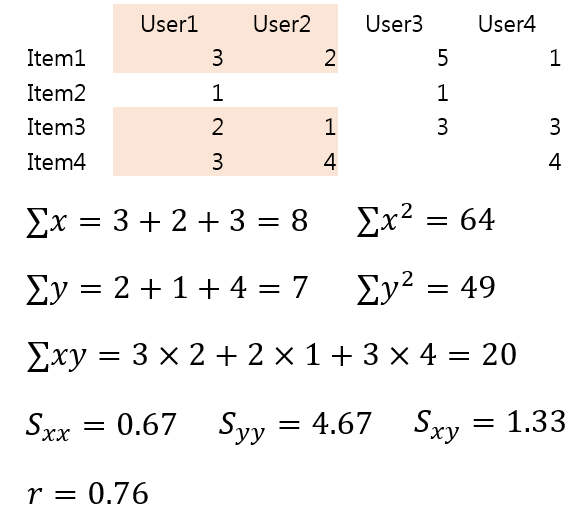

`calc_corr` : 모든 User 짝에 대해 Pearson correlation을 구합니다. 이 데모에서는 시간상 미리 구한 값을 불러오도록 하였습니다.

`predict` : 주어진 user_id에 대해 User간 Pearson correlation과 User rating을 기반으로 Unrated item에 대한 Ratings 예측값을 반환합니다.

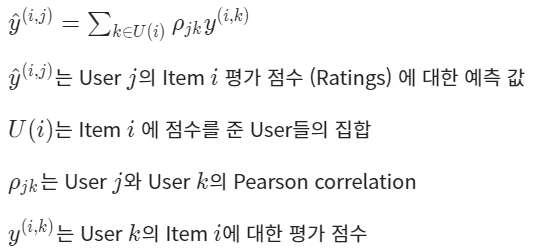

In [2]:
import pandas as pd
import numpy as np
import operator

def data_to_dict(id1, id2, ratings):
    dict_data = {}

    for _id1_ in sorted(ratings[id1].unique()):
        indices = (ratings[id1] == _id1_)
        
        dict_data[_id1_] = {}
        
        for _id2_, rating in zip(ratings[indices][id2], ratings[indices]['rating']):
            dict_data[_id1_][_id2_] = float(rating)
    
    return dict_data

def pearson_correlation(dict_data, user1, user2):
    # To get both rated users
    both_rated = {}
    for item in dict_data[user1]:
        if item in dict_data[user2]:
            both_rated[item] = 1

    number_of_ratings = len(both_rated)        
    
    # Checking for number of ratings in common
    if number_of_ratings == 0:
        return 0

    # Add up all the preferences of each item
    user1_preferences_sum = sum([dict_data[user1][item] for item in both_rated])
    user2_preferences_sum = sum([dict_data[user2][item] for item in both_rated])

    # Sum up the squares of preferences of each item
    user1_square_preferences_sum = sum([pow(dict_data[user1][item],2) for item in both_rated])
    user2_square_preferences_sum = sum([pow(dict_data[user2][item],2) for item in both_rated])

    # Sum up the product value of both preferences for each item
    product_sum_of_both_items = sum([dict_data[user1][item] * dict_data[user2][item] for item in both_rated])

    # Calculate the pearson score
    numerator_value = product_sum_of_both_items - (user1_preferences_sum * user2_preferences_sum / number_of_ratings)
    denominator_value = np.sqrt((user1_square_preferences_sum - pow(user1_preferences_sum, 2) / number_of_ratings) \
    * (user2_square_preferences_sum - pow(user2_preferences_sum, 2) / number_of_ratings))
    
    if denominator_value == 0:
        return 0
    else:
        r = numerator_value/denominator_value
        return r

def calc_corr(dict_data):
    M = len(dict_data)
    corr = np.ones([M + 1, M + 1])
    
    for i in range(1, M + 1):
        for j in range(i + 1, M + 1):
            corr[i, j] = pearson_correlation(dict_data, i, j)
            corr[j, i] = corr[i, j]
    
    np.save('corr_user.npy',corr)
    
    return corr

def predict(ratings, dict_data, corr, user):
    # Define a dictation for seen movies 
    seen_dict = {}
    
    # Obtain ratings of seen movies rated by the user
    for movie, rating in zip(ratings[(ratings['user_id'] == user)]['movie_id'], ratings[(ratings['user_id'] == user)]['rating']):
        seen_dict[movie] = float(rating)
    
    # Define a dictation for unseen movies 
    unseen_dict = {}
    
    # Obtain IDs of unseen movies 
    unseen_movies = set(movie_user_data) - set(ratings[(ratings['user_id'] == user)]['movie_id'])
    
    users_list = set(dict_data.keys())
    
    # Predict ratings for unseen movies
    for unseen_movie in unseen_movies:
        # Define numerator and denominator
        numer = 0
        denom = 0
        
        # Calculate numerator and denominator
        for other in users_list:
            if corr[user, other] > 0 and unseen_movie in dict_data[other]:
                numer += corr[user, other] * dict_data[other][unseen_movie]
                denom += corr[user, other]
                
        # Predict for the uncorrelated item
        if denom == 0:
            unseen_dict[unseen_movie] = np.mean(ratings[(ratings['movie_id'] == unseen_movie)]['rating'].astype('float64'))
            
        # Predict for the correlated item
        else:
            unseen_dict[unseen_movie] = numer / denom
                   
    return sorted(unseen_dict.items(), key = operator.itemgetter(1))

# Reading users file
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=u_cols,
 encoding='latin-1')

# Reading ratings file
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=r_cols,
 encoding='latin-1')

# Reading items file
i_cols = ['movie_id', 'movie title' ,'release date','video release date', 'IMDb URL', 'unknown', 'Action', 'Adventure',
 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
items = pd.read_csv('ml-100k/u.item', sep='|', names=i_cols,
 encoding='latin-1')

# Change data from pandas table to dictionary
movie_user_data = data_to_dict('movie_id', 'user_id', ratings)
user_movie_data = data_to_dict('user_id', 'movie_id', ratings)

# Calculate correlation among items
try:
    corr = np.load('corr_user.npy')
except:
    corr = calc_corr(user_movie_data)

# Recommend movies by predicting ratings
user_id = 200

recommendation = predict(ratings, user_movie_data, corr, user_id)
toprated = sorted(user_movie_data[user_id].items(), key = operator.itemgetter(1))

recommendation.reverse()
toprated.reverse()

print('Top 10 recommendation movies list for user')
for mov, rat in recommendation[:10]:
    title = items.loc[items['movie_id'] == mov]['movie title'].values
    genre = items.columns.values[np.where((items.loc[items['movie_id'] == mov] == 1).values.squeeze())]
    print(title, genre)
    
print('\n')
print('Top 10 rated movies list by user')
for mov, rat in toprated[:10]:
    title = items.loc[items['movie_id'] == mov]['movie title'].values
    genre = items.columns.values[np.where((items.loc[items['movie_id'] == mov] == 1).values.squeeze())]
    print(title, genre)

Top 10 recommendation movies list for user
['Entertaining Angels: The Dorothy Day Story (1996)'] ['Drama']
["Someone Else's America (1995)"] ['Drama']
['Aiqing wansui (1994)'] ['Drama']
['Santa with Muscles (1996)'] ['Comedy']
['Saint of Fort Washington, The (1993)'] ['Drama']
['Star Kid (1997)'] ['Adventure' "Children's" 'Fantasy' 'Sci-Fi']
['Marlene Dietrich: Shadow and Light (1996) '] ['Documentary']
['Prefontaine (1997)'] ['Drama']
['They Made Me a Criminal (1939)'] ['Crime' 'Drama']
['Great Day in Harlem, A (1994)'] ['Documentary']


Top 10 rated movies list by user
['Day the Earth Stood Still, The (1951)'] ['Drama' 'Sci-Fi']
['Scream (1996)'] ['Horror' 'Thriller']
['Back to the Future (1985)'] ['Comedy' 'Sci-Fi']
['Aliens (1986)'] ['Action' 'Sci-Fi' 'Thriller' 'War']
['Empire Strikes Back, The (1980)'] ['Action' 'Adventure' 'Drama' 'Romance' 'Sci-Fi' 'War']
['Star Trek: Generations (1994)'] ['Action' 'Adventure' 'Sci-Fi']
['Star Trek IV: The Voyage Home (1986)'] ['Action' 'Advent

---

### 1-3. Latent Factor Model

이번에는 Low dimensional matrix factorization을 이용해 Latent Factor Model을 구현하겠습니다.

item 혹은 user 간의 correlation 만으로 Unrated item의 점수를 추측하였던 CF와 달리 Latent Factor Model에서는 item과 user 각각의 성향 벡터(latent vector)를 찾아 Unrated item의 점수를 추측합니다.

Low dimensional matrix factorization을 하기 위한 방법으로 Gradient descent 알고리즘을 사용하여 Error function의 값을 최소화합니다.

### 실습

1. `user_factor_grad` 함수를 완성하세요. `user_factor_grad`함수는 현재 Search point `theta`(θ)를 입력으로 받아 Error function의 기울기(Gradient) 값을 반환합니다.

$$\nabla_{\theta^{(j)}} f = \sum^{N_m}_{i=1} r(i,j) X^{(i)} ((\theta^{(j)})^T X^{(i)} - y^{(i,j)}) + \lambda \theta^{(j)}$$

- $N_m$ : item 수
- $r(i,j)$ : j번째 user가 i번째 item에 점수를 주면 1, 아니면 0
- $\theta^{(j)}$ : j번째 user의 latent vector
- $X^{(i)}$ : i번째 item의 latent vector
- $y^{(i,j)}$ : j번째 user가 i번째 item에 준 점수(rating)
- $\lambda$ : regularization factor

2. `item_factor_grad` 함수를 완성하세요. `item_factor_grad` 함수는 현재 Search point `X`를 입력으로 받아 Error function의 기울기 값을 반환합니다.

$$
\nabla_{X^{(i)}} f = \sum^{N_u}_{j=1} r(i,j) \theta^{(j)} ((\theta^{(j)})^T X^{(i)} - y^{(i,j)}) + \lambda X^{(i)}
$$

- $N_u$ : user 수

In [3]:
import numpy as np
import pandas as pd

def user_factor_grad(data, theta, X, lam):
    # Implement Here
    g = np.matmul(np.nan_to_num(np.matmul(X,theta.T)-data).T,X) + lam * theta
    # nan_to_num : nan을 특정 숫자로 mapping함. default : 0
    # lam앞의 값까지 gradient 조절해주는 값이 된다.
    return g

def item_factor_grad(data, theta, X, lam):
    # Implement Here
    g = np.matmul(np.nan_to_num(np.matmul(X,theta.T)-data),theta) + lam * X
    
    return g

def error_function(data, theta, X, lam):
    # Initialize error function value
    f = 0
    
    # Error values
    f += 0.5 * np.nansum(np.square(data - np.matmul(X, theta.T)))
    
    # Ridge penalty values
    f += 0.5 * lam * (np.sum(np.square(theta)) + np.sum(np.square(X)))
    
    return f

def gradient_descent(data, theta0, X0, lam, alpha, max_iter, fun_tol):
    # Initialize parameters
    num_iter = 1
    diff = fun_tol + 1
    
    # Initialize search points
    theta = np.copy(theta0)
    X = np.copy(X0)
    
    prev_f = error_function(data, theta, X, lam)
    
    print('Run gradient descent algorithm')
    print('iter : %d, error : %.3f' % (num_iter, prev_f))
    
    while num_iter < max_iter and diff > fun_tol:
        # Print
        if num_iter % 20 == 0:
            print('iter : %d, error : %.3f' % (num_iter, prev_f))
        
        # Update user factor
        theta_grad = user_factor_grad(data, theta, X, lam)
        theta = theta - alpha * theta_grad
        
        # Update item factor
        X_grad = item_factor_grad(data, theta, X, lam)
        X = X - alpha * X_grad
        
        # Update error function value
        next_f = error_function(data, theta, X, lam)
        
        # Update parameters
        diff = abs(next_f - prev_f)
        prev_f = next_f
        num_iter += 1
    
    print('Terminated')
    return theta, X, next_f

def main():
    # Set up dataset
    data = np.array([[5, 5, 0, 0],
                     [5, np.nan, np.nan, 0],
                     [np.nan, 4, 0, np.nan],
                     [0, 0, 5, 4],
                     [0, 0, 5, np.nan]])
    
    user = ['NoSyu', 'Jin', 'Yeong', 'Bak']
    item = ['TRAIN TO BUSAN', 'Captain America: Civil War', 'THE WAILING', 'La La Land', 'Bridget Jones`s Baby']
    
    # Print dataset
    print('Print dataset')
    print(pd.DataFrame(data = data, index = item, columns = user))
    
    # Initialize user and item factors
    K = 3
    Nm = data.shape[0]
    Nu = data.shape[1]
    
    theta0 = np.random.normal(size = [Nu, K])
    X0 = np.random.normal(size = [Nm, K])
    
    # Initialize parameters # 정규화
    lam = 0.5
    alpha = 1e-2
    max_iter = 1000 # 최적화수
    fun_tol = 1e-3 # loss function이 더이상 이 값보다 감소하지않을 때 멈춤을 설정하는 threshold
    
    # Run gradient descent algorithm
    theta, X, next_f = gradient_descent(data, theta0, X0, lam, alpha, max_iter, fun_tol)
    
    # Print predictions of unrated items
    preds = np.matmul(X, theta.T)
    pd.options.display.float_format = '{:,.1f}'.format
    print(pd.DataFrame(data = preds, index = item, columns = user))
    
    print('Print predictions of unrated items')
    for i in range(Nm):
        for j in range(Nu):
            if np.isnan(data[i, j]):
                print('Predict rating of %s for %s is %.2f' % (item[i], user[j], preds[i, j]))
    
    return

if __name__ == '__main__':
    main()


Print dataset
                            NoSyu  Jin  Yeong  Bak
TRAIN TO BUSAN                5.0  5.0    0.0  0.0
Captain America: Civil War    5.0  NaN    NaN  0.0
THE WAILING                   NaN  4.0    0.0  NaN
La La Land                    0.0  0.0    5.0  4.0
Bridget Jones`s Baby          0.0  0.0    5.0  NaN
Run gradient descent algorithm
iter : 1, error : 92.138
iter : 20, error : 25.802
iter : 40, error : 12.410
iter : 60, error : 10.935
iter : 80, error : 10.628
iter : 100, error : 10.470
iter : 120, error : 10.363
iter : 140, error : 10.283
iter : 160, error : 10.220
iter : 180, error : 10.169
iter : 200, error : 10.128
iter : 220, error : 10.094
iter : 240, error : 10.066
iter : 260, error : 10.042
Terminated
                            NoSyu  Jin  Yeong  Bak
TRAIN TO BUSAN                4.8  4.7   -0.0  0.0
Captain America: Civil War    4.6  4.3   -0.8 -0.0
THE WAILING                   3.6  3.6    0.0 -0.2
La La Land                    0.1 -0.1    4.8  3.6
Bridget Jon